In [1]:
import numpy as np
import pandas as pd

from util import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef, ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras import models, layers, losses, metrics, activations

In [2]:
df = pd.read_csv("creditcard.csv").drop(columns="Time")

In [3]:
X, y = df.drop(columns="Class"), df.Class

In [16]:
y.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [17]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X[y==0], y[y==0], test_size=0.5, random_state=23)

In [22]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=0.2, random_state=123)

In [27]:
X_train = pd.concat((X1_train, X0_train))
X_test = pd.concat((X1_test, X0_test))
y_train = pd.concat((y1_train, y0_train))
y_test = pd.concat((y1_test, y0_test))

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=225)

In [47]:
sc = MinMaxScaler().fit(X_train)

In [48]:
class Autoencoder(models.Model):
    def __init__(self, true, latent):
        super(Autoencoder, self).__init__()
        self.encoder = models.Sequential([
            layers.Dense(latent, activation="tanh")
        ], name="encoder")
        
        self.decoder = models.Sequential([
            layers.Dense(true, activation="sigmoid")
        ])
        
    def call(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

In [49]:
ae = Autoencoder(29, 10)

In [50]:
ae.compile("adam", loss="mse")

In [81]:
ae.fit(
    sc.transform(X_train), 
    sc.transform(X_train), 
    batch_size=128, 
    epochs=1, 
    validation_data=(sc.transform(X_test), sc.transform(X_test))
)

1781/1781 [==============================] - 9s 5ms/step - loss: 4.4736e-04 - val_loss: 4.4137e-04


In [82]:
ae.encoder(sc.transform(X_train[:1]))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.9968368 , -0.05677959, -0.32200176, -0.8103597 , -0.14163107,
         0.22009885, -0.13093638,  0.14889714,  0.12097643, -0.2685598 ]],
      dtype=float32)>

### Encoder Representation for SVM

In [83]:
X_train_=ae.encoder(sc.transform(X_train))

In [84]:
X_test_ = ae.encoder(sc.transform(X_test))

In [85]:
svc = SVC().fit(X_train_, y_train)
print("Train score = ", svc.score(X_train_, y_train))
print("Test score = ", svc.score(X_test_, y_test))

Train score =  0.9993372687572692
Test score =  0.999385555282469


In [86]:
preds = svc.predict(X_test_)
matthews_corrcoef(y_test, preds)

0.802994941363725

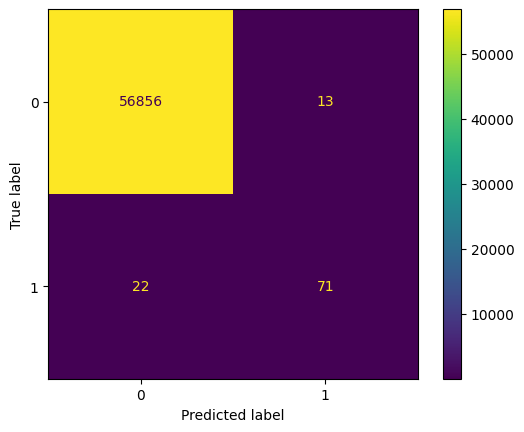

In [87]:
ConfusionMatrixDisplay(confusion_matrix(y_test,preds)).plot()

### Encoder Representation for feedforward network

In [88]:
ae.encoder.trainable=False

In [90]:
model = models.Sequential([
    ae.encoder,
    layers.Dense(15, "relu"),
    layers.Dense(1, "sigmoid")
])

In [91]:
model.compile(loss="binary_crossentropy", metrics=[metrics.Recall()])

In [107]:
model.fit(
    sc.transform(X_train), y_train,
    batch_size=128,
    validation_data=( sc.transform(X_test), y_test )
)

1781/1781 [==============================] - 14s 8ms/step - loss: 0.0049 - recall_1: 0.7243 - val_loss: 0.0042 - val_recall_1: 0.7742


In [108]:
preds = (np.array(model(sc.transform(X_test)))>=0.5)*1
matthews_corrcoef(y_test, preds)

0.8095110133790718

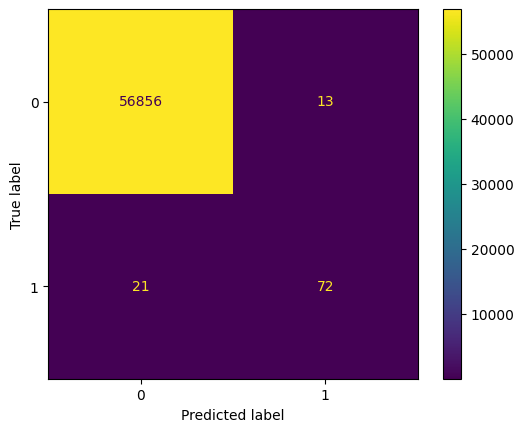

In [109]:
ConfusionMatrixDisplay(confusion_matrix(y_test,preds)).plot()